<a href="https://colab.research.google.com/github/lava99-bliss/Tensorflow/blob/main/04_tranfer_learning_in_tensorflow_Part_01_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Transfer learning**

taking the patterns (also called weights) another model has learned from another problem and using them for our own problem.

There are two main benefits to using transfer learning:

1.  Can leverage an existing neural network architecture proven to work on problems similar to our own.
2.  Can leverage a working neural network architecture which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.



Here, we only use 10% training data.(75)

In [23]:
#Are we using a GPU
!nvidia-smi
#GPU -Tesla T4

Fri Jul 14 13:37:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    32W /  70W |   4931MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [24]:
#Get data
import zipfile

#download data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip
zip_ref=zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2023-07-14 13:37:01--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   116MB/s    in 1.4s    

2023-07-14 13:37:02 (116 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [25]:
#how many images in each folder
import os

for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} diectories and {len(filenames)} images in '{dirpath}")

There are 2 diectories and 0 images in '10_food_classes_10_percent
There are 10 diectories and 0 images in '10_food_classes_10_percent/test
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/ice_cream
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/chicken_curry
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/hamburger
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/pizza
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/ramen
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/sushi
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/fried_rice
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/chicken_wings
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/steak
There are 0 diectories and 250 images in '10_food_classes_10_percent/test/grilled_salmon
There are 10 diectorie

#Creting data loaders(preparing data)
###we'll use ImageDataGenerator class to load in our imgs into batches



In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test/'

train_datagen=ImageDataGenerator(rescale=1/225.)
test_datagen=ImageDataGenerator(rescale=1/225.)

#augmented data set
print("Training images:")
train_data_10_percent= train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")

print("Testing images:")
test_data_10_percent= train_datagen.flow_from_directory(test_dir,
                                                         target_size=IMAGE_SHAPE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


#setting up callbacks

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks include:

Experiment tracking with,
1.   TensorBoard - log the performance of multiple models and then view and compare these models in a visual way on TensorBoard (a dashboard for inspecting neural network parameters). Helpful to compare the results of different models on your data.
2.   Model checkpointing - save your model as it trains so you can stop training if needed and come back to continue off where you left. Helpful if training takes a long time and can't be done in one sitting.
3.   Early stopping - leave your model training for an arbitrary amount of time and have it stop training automatically when it ceases to improve. Helpful when you've got a large dataset and don't know how long training will take.
We'll explore each of these overtime but for this notebook, we'll see how the TensorBoard callback can be used.

In [27]:
#create TensorBoard callback (functionalized becue we need to create a new one for each model)\
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir=dir_name+"/"+experiment_name+"/"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving tensorboard log files to :{log_dir}")
  return tensorboard_callback

#Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

In fact, we're going to use two models from TensorFlow Hub:

In fact, we're going to use two models from TensorFlow Hub:

ResNetV2 - a state of the art computer vision model architecture from 2016.
EfficientNet - a state of the art computer vision architecture from 2019.
State of the art means that at some point, both of these models have achieved the lowest error rate on ImageNet (ILSVRC-2012-CLS), the gold standard of computer vision benchmarks.

You might be wondering, how do you find these models on TensorFlow Hub?

Here are the steps I took:

Go to tfhub.dev.
Choose your problem domain, e.g. "Image" (we're using food images).
Select your TF version, which in our case is TF2.
Remove all "Problem domanin" filters except for the problem you're working on.
Note: "Image feature vector" can be used alongside almost any problem, we'll get to this soon.
The models listed are all models which could potentially be used for your problem.

#Let's compare two models

In [28]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [29]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [30]:
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [31]:
#create_model() to create a model from URL

"""
  takes Tensorflow_hub url and create a seq model.

  Args:
    model_url - tensoflow hub feature extrction url
    num_classes - no of output neurons in utput layer

  Returns:
    An uncompiled keras seq model with model_url as feature extractor layer and dense output layer with num_classes output neurons

"""

def create_model(model_url,num_classes=10):

#download pretrained model and save it as a keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model


In [32]:

#Create resnet_model model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)


In [33]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [34]:
#compile resnet_model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["Accuracy"])

In [35]:
# Fit the model
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log files


Saving tensorboard log files to :tensorflow_hub/resnet50V2/20230714-133708
Epoch 1/5
24/24 [==============================] - 23s 786ms/step - loss: 2.0860 - Accuracy: 0.2987 - val_loss: 1.2673 - val_Accuracy: 0.6168
Epoch 2/5
24/24 [==============================] - 18s 776ms/step - loss: 0.9614 - Accuracy: 0.7187 - val_loss: 0.9112 - val_Accuracy: 0.7068
Epoch 3/5
24/24 [==============================] - 18s 761ms/step - loss: 0.6607 - Accuracy: 0.8133 - val_loss: 0.7893 - val_Accuracy: 0.7476
Epoch 4/5
24/24 [==============================] - 20s 853ms/step - loss: 0.5094 - Accuracy: 0.8733 - val_loss: 0.7255 - val_Accuracy: 0.7744
Epoch 5/5
24/24 [==============================] - 18s 754ms/step - loss: 0.3952 - Accuracy: 0.9093 - val_loss: 0.7022 - val_Accuracy: 0.7740


Wow!

It seems that after only 5 epochs, the ResNetV250 feature extraction model was able to blow any of the architectures we made out of the water, achieving around 90% accuracy on the training set and nearly 80% accuracy on the test set...**with only 10 percent of the training images!**

That goes to show the power of transfer learning. And it's one of the main reasons whenever you're trying to model your own datasets, you should look into what pretrained models already exist.

Let's check out our model's training curves using our plot_loss_curves function.

In [36]:
# If you wanted to, you could really turn this into a helper function to load in with a helper.py script...
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['Accuracy']
  val_accuracy = history.history['val_Accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_Accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

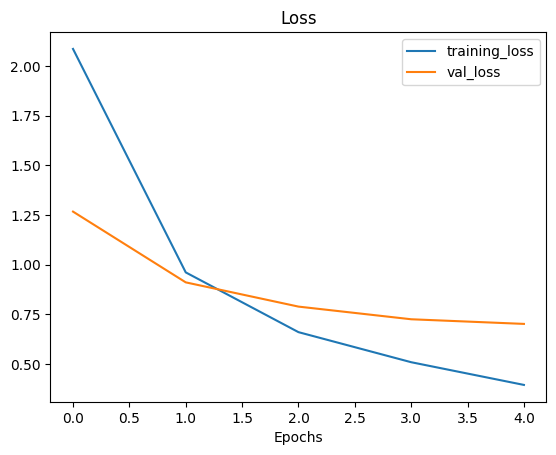

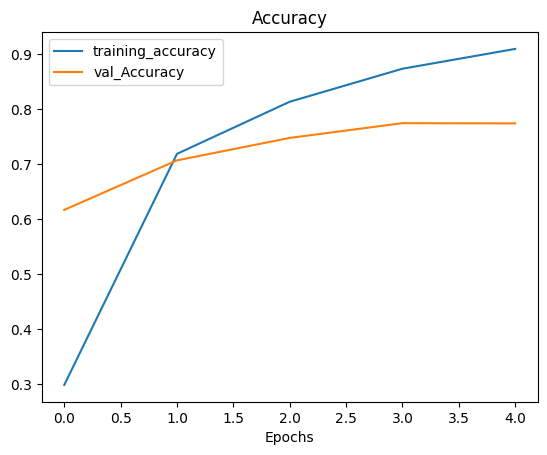

In [37]:
plot_loss_curves(resnet_history)

In [38]:
resnet_model.metrics_names


['loss', 'Accuracy']

##Creating and testing EfficientNetB0 Tensorflow Hub feature Extraction model

In [41]:

#Create EfficientNetB0 model
efficientnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

#compile
efficientnet_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["Accuracy"])

# Fit the model
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data_10_percent,
                                  validation_steps=len(test_data_10_percent),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="efficientnetb0")]) # name of log files


Saving tensorboard log files to :tensorflow_hub/efficientnetb0/20230714-134121
Epoch 1/5
24/24 [==============================] - 38s 1s/step - loss: 1.9184 - Accuracy: 0.3573 - val_loss: 1.3418 - val_Accuracy: 0.6944
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 1.1194 - Accuracy: 0.7507 - val_loss: 0.9116 - val_Accuracy: 0.7980
Epoch 3/5
24/24 [==============================] - 24s 1s/step - loss: 0.7999 - Accuracy: 0.8200 - val_loss: 0.7320 - val_Accuracy: 0.8312
Epoch 4/5
24/24 [==============================] - 17s 728ms/step - loss: 0.6385 - Accuracy: 0.8560 - val_loss: 0.6408 - val_Accuracy: 0.8464
Epoch 5/5
24/24 [==============================] - 17s 726ms/step - loss: 0.5375 - Accuracy: 0.8827 - val_loss: 0.5818 - val_Accuracy: 0.8544


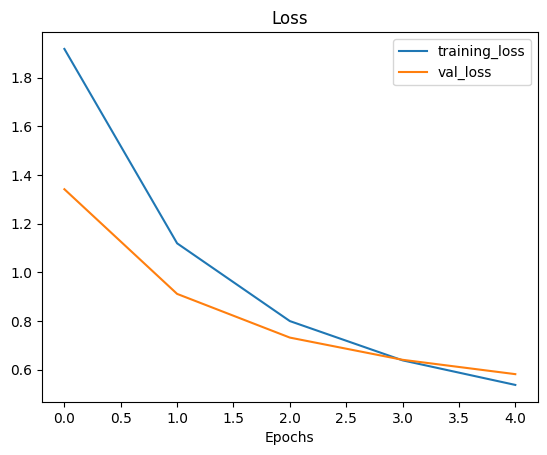

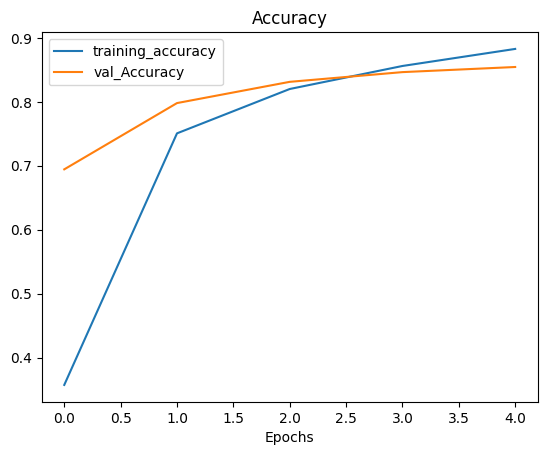

In [42]:
plot_loss_curves(efficientnet_history)

Great observation. This is where the differnet types of transfer learning come into play, as is, feature extraction and fine-tuning.

1. "As is" transfer learning is when you take a pretrained model as it is and apply it to your task without any changes.
For example, many computer vision models are pretrained on the ImageNet dataset which contains 1000 different classes of images. This means passing a single image to this model will produce 1000 different prediction probability values (1 for each class).

This is helpful if you have 1000 classes of image you'd like to classify and they're all the same as the ImageNet classes, however, it's not helpful if you want to classify only a small subset of classes (such as 10 different kinds of food). Model's with "/classification" in their name on TensorFlow Hub provide this kind of functionality.

2. Feature extraction transfer learning is when you take the underlying patterns (also called weights) a pretrained model has learned and adjust its outputs to be more suited to your problem.
For example, say the pretrained model you were using had 236 different layers (EfficientNetB0 has 236 layers), but the top layer outputs 1000 classes because it was pretrained on ImageNet. To adjust this to your own problem, you might remove the original activation layer and replace it with your own but with the right number of output classes. The important part here is that only the top few layers become trainable, the rest remain frozen.

This way all the underlying patterns remain in the rest of the layers and you can utilise them for your own problem. This kind of transfer learning is very helpful when your data is similar to the data a model has been pretrained on.

3. Fine-tuning transfer learning is when you take the underlying patterns (also called weights) of a pretrained model and adjust (fine-tune) them to your own problem.

This usually means training some, many or all of the layers in the pretrained model. This is useful when you've got a large dataset (e.g. 100+ images per class) where your data is slightly different to the data the original model was trained on.

#Compare models using TensorBoard

To upload a series of TensorFlow logs to TensorBoard, we can use the following command:

Upload TensorBoard dev records

!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot
Where:

--logdir is the target upload directory
--name is the name of the experiment
--description is a brief description of the experiment
--one_shot exits the TensorBoard uploader once uploading is finished
Running the tensorboard dev upload command will first ask you to authorize the upload to TensorBoard.dev. After you've authorized the upload, your log files will be uploaded.

In [43]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-07-14 14:01:01.065944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./tensorflow_hub/

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   LLQ-PQC-WXQ



New experiment created. View your TensorBoard at: https://tensorboard.dev/ex

###Tensoboard chart link -  https://tensorboard.dev/experiment/8g73IbAFQgupLLuxvE4jVQ/

In [46]:
#check the details on tensorboard

!tensorboard dev list

2023-07-14 14:07:28.405954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/8g73IbAFQgupLLuxvE4jVQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   8g73IbAFQgupLLuxvE4jVQ
	Created              2023-07-14 14:03:04 (4 minutes ago)
	Updated              2023-07-14 14:03:09 (4 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              150
	Tensor bytes         0
	Binary object bytes  11490212
Total: 1 experiment(s)


In [47]:
#delete an experiment
!tensorboard dev delete --experiment_id 8g73IbAFQgupLLuxvE4jVQ

2023-07-14 14:08:37.437096: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Deleted experiment 8g73IbAFQgupLLuxvE4jVQ.


In [48]:
#confirm deletion
!tensorboard dev list

2023-07-14 14:08:59.881339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
No experiments. Use `tensorboard dev upload` to get started.
